In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

import gammapy
import numpy as np
import astropy
import regions
import scipy

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("scipy", scipy.__version__)


from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle

from regions import CircleSkyRegion

from gammapy.data import DataStore, GTI, Observation, EventList
from gammapy.datasets import (FluxPointsDataset, MapDataset, MapDatasetEventSampler, 
                              Datasets, SpectrumDataset, SpectrumDatasetOnOff)
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SafeMaskMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    TemplateSpectralModel,
    FoVBackgroundModel,
)


import copy
import scipy.stats as stats

from gammapy.estimators import (
    FluxPoints, 
    FluxPointsEstimator, 
    TSMapEstimator
)

from regions import CircleSkyRegion

gammapy: 1.3
numpy: 2.1.3
astropy 6.1.6
regions 0.10
scipy 1.14.1


In [2]:
BASE_PATH=Path(".")

In [3]:
dataset = MapDataset.read('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/dataset_NGC1068_50hr.fits')

In [4]:
center = SkyCoord.from_name("NGC 1068").icrs

offset = 0.5 * u.deg

pointing_position = center.directional_offset_by(position_angle=0 * u.deg, separation=offset)

ENERGY_AXIS = MapAxis.from_energy_bounds(
    "0.1 TeV", "100.0 TeV", nbin=10, per_decade=True       #IRF range
)
    

WCS_GEOM = WcsGeom.create(
    skydir=pointing_position,
    width=(10, 10),         #REMEMBER: if you want to point off-axis 4°, you need a wider field     
    binsz=0.02,          #binsize simulation << PSF 
    frame="icrs",
    axes=[ENERGY_AXIS],
)

e_min, e_max, e_bins = 0.1, 100.0, 10
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), e_bins) * u.TeV

dataset_original = Models.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/NGC1068_Nsim_Fermi.yaml") 

In [5]:
# spectral_model = PowerLawSpectralModel(
#     amplitude = 6.35e-14  * u.Unit("cm-2 s-1 TeV-1"),
#     index = 2.3,
#     reference = 1 * u.TeV,
# )

spectral_model = ExpCutoffPowerLawSpectralModel(
   amplitude = 6.35e-14 * u.Unit("cm-2 s-1 TeV-1"),
   index = 2.3,
   lambda_ = 0.1  * u.Unit("TeV-1"),
   reference = 1 * u.TeV,
   #alpha = 3.95
)

# Source
point_model = PointSpatialModel(
    lon_0="40.669 deg", 
    lat_0="-0.013 deg", 
    frame='icrs'
)

MainSourceAn = "NGC1068_Fermi"   

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=point_model,
 #                   temporal_model=expdecay_model,
                    name=MainSourceAn,
                    )

# Define the whole model
models = Models([sky_model, bkg_model])


models[0].spatial_model.parameters['lon_0'].frozen=True       #Spatial coordinate freezed
models[0].spatial_model.parameters['lat_0'].frozen=True

In [6]:
%%time

MainSource = "NGC1068"

BASE_PATH=Path(".")

def save_figure(filename):       #routine for saving figures
    path = BASE_PATH / filename      #saving paths
    path.parent.mkdir(parents=True, exist_ok=True)  #create a directory
    plt.savefig(path, dpi=300, bbox_inches='tight')     #dpi is the resolution
    plt.clf()                #clear
    plt.close()

exp = [50]  
Nsim = 100 
dataset_original = Models.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/NGC1068_Nsim_Fermi.yaml") 

e_min, e_max, e_bins = 0.1, 100.0, 10
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), e_bins) * u.TeV

for j in np.array([exp]):            # for every exposure time
    ext = int(j)
    print(f"Exposure time: {ext} hr")
    for i in np.arange(Nsim):    #for each of the N simulations
        dataset = MapDataset.read(f'dataset_{MainSource}_{ext}hr.fits')
        dataset.models = models
        print(f"  Read events: {i}")
        events = EventList.read(f"./{Nsim}sims/events/{MainSource}_{ext}hr_events_{i}.fits")
        counts = Map.from_geom(WCS_GEOM)
        counts.fill_events(events)
        dataset.counts = counts

        print(f"    Fit data ...")
        fit = Fit(optimize_opts={"print_level": 1})
        result = fit.run([dataset])
        dataset.models.write(f"./{Nsim}sims/best-fit/{MainSource}_{ext}hr_best-fit_{i}.yaml", overwrite=True)

        # print(f"    Calculate flux points ...")
        # fpe = FluxPointsEstimator(energy_edges=e_edges, source=MainSourceAn, n_sigma=1, n_sigma_ul=3, n_jobs=7)
        # flux_points = fpe.run(datasets=dataset)
        # flux_points.sqrt_ts_threshold_ul = 3
        # flux_points.write(f"./Test/spectra/{MainSource}_{ext}hr_spectrum_{i}.fits", overwrite=True)

        # print(f"    Plot spectra ...")
        # ax = dataset_original[0].spectral_model.plot(
        #     energy_bounds=(0.1, 100) * u.TeV, 
        #     label="Sim. model",
        #     sed_type="e2dnde",
        #     color='black'
        # )

        # px = {"color": "red", "marker":"o"}
        # mx = {"color": "blue"}

        # flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[0])
        # flux_points_dataset.plot_spectrum(ax=ax, kwargs_fp=px, kwargs_model=mx)
        # ax.legend()
        # #ax.set_ylim(2e-14,1e-12)
        # filename = f"./Test/plots_{ext}hr/{MainSource}_spectrum_{i}.png"
        # save_figure(filename)

<timed exec>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Exposure time: 50 hr
  Read events: 0
    Fit data ...
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0467574
W MnPosDef Added to diagonal of Error matrix a value 0.546757
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef Matrix forced pos-def by adding to diagonal 0.379742
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00164533 is smaller than machine limit 0.405113 while 0.0002 was requested
  Read events: 1
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limit

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 1257.37 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0509472 is smaller than machine limit 0.404021 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0509472 is above tolerance 0.002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W DavidonErrorUpdator gvg <= 0 : cannot update - return same matrix
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
  Read events: 6
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00357602 is smaller than machine limit 0.404555 while 0.0002 was requested
W VariableMetricBuil

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 468.332 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00282704 is smaller than machine limit 0.40426 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00282704 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 7.51787 Requested 0.0002
  Read events: 8
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0301275 is smaller than machine limit 0.404623 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0301275 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine a

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 3447.13 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.182759 is smaller than machine limit 0.405229 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.182759 is above tolerance 0.002
W SimplexBuilder Simplex did not converge, edm > minedm
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 3.64654 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000386573 is smaller than machine limit 0.405229 while 0.0002 was requested
  Read events: 12
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0874056 is smaller than machine limit 0.403796 while 0.0002 was re

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.826838 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00652043 is smaller than machine limit 0.404594 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00652043 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 1.98269 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00314973 is smaller than machine limit 0.404594 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00314973 is above tolerance 0.002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000371764 is smaller than machine limit 0.404594 while 0.0002 was requested
  Read events: 47
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish with

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.929841 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0139509 is smaller than machine limit 0.405644 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0139509 is above tolerance 0.002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00169537 is smaller than machine limit 0.405644 while 0.0002 was requested
  Read events: 66
    Fit data ...
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.17322
W MnPosDef Added to diagonal of Error matrix a value 0.67322
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.625904 Requested 0.0002
  Read eve

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0013448 is smaller than machine limit 0.403251 while 0.0002 was requested
  Read events: 69
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00218255 is smaller than machine limit 0.404693 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00218255 is above tolerance 0.002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 0.00341724 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.239482
W MnPosDef Added to diagonal of Error matrix a value 0.739482
W VariableMetricBuilder g

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/qua

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000582985 is smaller than machine limit 0.404222 while 0.0002 was requested
  Read events: 73
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 9.82041 Requested 0.0002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.00800371
W MnPosDef Added to diagonal of Error matrix a value 0.508004
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 1.38157 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetric

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quant

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 1.27266 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0786027 is smaller than machine limit 0.404374 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0786027 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
  Read events: 82
    Fit data ...
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.0213997 is smaller than machine limit 0.404526 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.0213997 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergen

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 2339.9 Requested 0.0002
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.000329548 is smaller than machine limit 0.404384 while 0.0002 was requested
  Read events: 84
    Fit data ...
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Edm is limited by Machine accuracy - return current minimum
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.207334 is smaller than machine limit 0.40398 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.207334 is above tolerance 0.002
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line (details in info log)
W VariableMetricBuilder Matrix not pos.def, gdel = 0.027211 > 0
W MnPosDef non-positive diagonal element in covariance matri

: 

In [7]:
rows = []
BASE_PATH=Path(".")
path = (BASE_PATH / f"{Nsim}sims/best-fit")
exp = [50] 
MainSource = "NGC1068" 

for j in np.array([exp]):           # for every exposure
    ext = int(j)
    print(f"Exposure time: {ext} hr")
    for filename in path.glob(f"{MainSource}*{ext}hr*best-fit*.yaml"):
        print(filename)
        model_best_fit = Models.read(filename)        #we read the best fit model for every simulation
        row = {}
        for par in model_best_fit[f'{MainSourceAn}'].spectral_model.parameters:   #we consider the spectral parameters for every sim
            row[par.name] = par.value
            row[par.name + "_err"] = par.error
            
        rows.append(row)
        print(row)
    
    table = Table(rows)
    print('###################################################################')
    print(table)
    filename = f"{Nsim}sims/best-fit/{MainSource}_{ext}hr_results.fits"
    table.write(str(filename), overwrite=True)

Exposure time: 50 hr
Test/best-fit/NGC1068_50hr_best-fit_1.yaml
{'index': 2.294508175943718, 'index_err': 0.11226969745658946, 'amplitude': 6.370271622135664e-14, 'amplitude_err': 9.992792607186217e-15, 'reference': 1.0, 'reference_err': 0.0, 'lambda_': -0.0006745559286651452, 'lambda__err': 0.018840933997585407, 'alpha': 1.0, 'alpha_err': 0.0}
Test/best-fit/NGC1068_50hr_best-fit_0.yaml
{'index': 1.9910523525142438, 'index_err': 0.2777617628213682, 'amplitude': 1.0485354902701147e-13, 'amplitude_err': 3.273247346046896e-14, 'reference': 1.0, 'reference_err': 0.0, 'lambda_': 0.32859310254650886, 'lambda__err': 0.15372455831494455, 'alpha': 1.0, 'alpha_err': 0.0}
Test/best-fit/NGC1068_50hr_best-fit_4.yaml
{'index': 2.245981221668709, 'index_err': 0.13192044611229842, 'amplitude': 6.464202240345034e-14, 'amplitude_err': 1.0801326980063995e-14, 'reference': 1.0, 'reference_err': 0.0, 'lambda_': 0.023061538495605584, 'lambda__err': 0.026800396586279796, 'alpha': 1.0, 'alpha_err': 0.0}
Test/

/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_19746/2266655777.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ext = int(j)


In [8]:
import scipy.optimize as optimization

def gaussian(x,norm,m,s):
    g = norm * np.exp(-0.5 * ((x-m)/s)**2)
    return g

/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_19746/180029779.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ext = int(j)


[np.float64(2.196919006789959), np.float64(7.771772456426128e-14), np.float64(0.09692934944349205)]
[np.float64(0.11394775508997376), np.float64(1.7760698823913415e-14), np.float64(0.12319432907133022)]


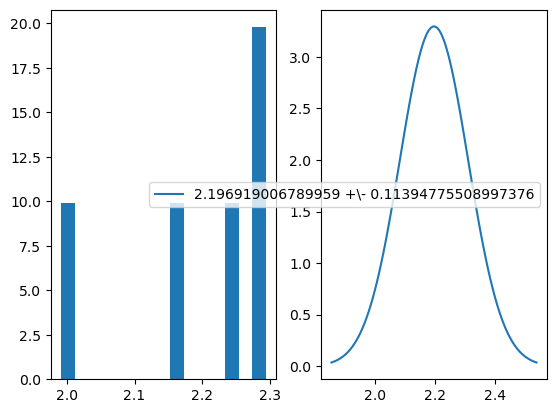

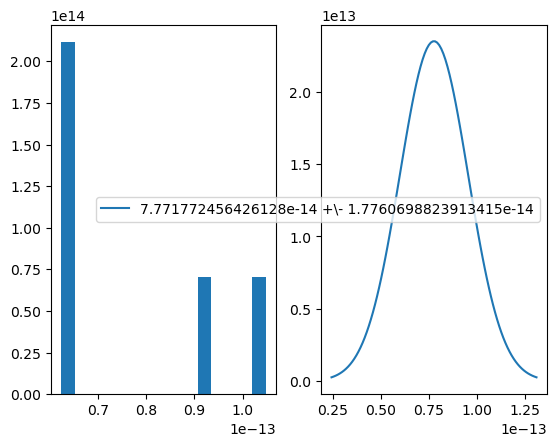

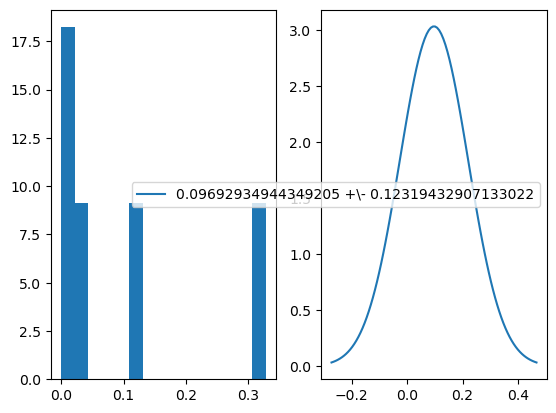

In [9]:
temp = np.array([exp])
par = np.array(['index','amplitude', 'lambda_'])
Res_mean = []
Res_sigma = []

for j in temp:              #for every exposure time
    ext = int(j)
    result = table.read(f"./{Nsim}sims/best-fit/{MainSource}_{ext}hr_results.fits")
    for name in par:        #loop over the parameters to be computed
        mean = np.mean(result[name])
        sigma = np.sqrt(np.var(result[name]))
        Res_mean.append(mean)
        Res_sigma.append(sigma)
            #fig = plt.figure()
            #n, bins, patches = plt.hist(result[name], bins=15, density=True)
        figure, axs = plt.subplots(1, 2)
        n, bins, patches = axs[0].hist(result[name], bins=15, density=True)
        x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
            #plt.figure()
            #plt.plot(x, gaussian(x, np.mean(n), mean, sigma), label=f"{mean} +\- {sigma}")
        axs[1].plot(x, gaussian(x, np.mean(n), mean, sigma), label=f"{mean} +\- {sigma}")
        plt.legend()
        filename = f"./{Nsim}sims/best-fit/{MainSource}_{name}_{ext}hr_hist.png"

print(Res_mean)
print(Res_sigma)

In [10]:
# Mean index and amplitude
mean_index, mean_amplitude, mean_lambda = Res_mean
print(f"Mean Index: {mean_index}, Mean Amplitude: {mean_amplitude},  Mean lambda: {mean_lambda}")

# Read result table again
ext = int(temp[0])
result = table.read(f"./{Nsim}sims/best-fit/{MainSource}_{ext}hr_results.fits")

# Calculate Euclidean distance for each simulation using all 3 parameters
distances = np.sqrt(
    (result["index"] - mean_index)**2 +
    (result["amplitude"] - mean_amplitude)**2 +
    (result["lambda_"] - mean_lambda)**2
)

# Find the index of the closest simulation
best_idx = np.argmin(distances)

print(f"Best matching simulation index: {best_idx}")
print(f"Index: {result['index'][best_idx]}, Amplitude: {result['amplitude'][best_idx]}, Lambda: {result['lambda_'][best_idx]}")

Mean Index: 2.196919006789959, Mean Amplitude: 7.771772456426128e-14,  Mean lambda: 0.09692934944349205
Best matching simulation index: 3
Index: 2.1599856615775277, Amplitude: 9.308126001932645e-14, Lambda: 0.11889868705160156


/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_19746/3094024067.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ext = int(temp[0])


In [11]:
events_best = EventList.read(f"./{Nsim}sims/events/{MainSource}_{ext}hr_events_{best_idx}.fits")
counts_best = Map.from_geom(WCS_GEOM)
counts_best.fill_events(events_best)

dataset_best = MapDataset.read(f'dataset_{MainSource}_{ext}hr.fits')
dataset_best.counts = counts_best
model_best = Models.read(f"./{Nsim}sims/best-fit/{MainSource}_{ext}hr_best-fit_{best_idx}.yaml")
dataset_best.models = model_best
dataset_best.models[0].spectral_model.index.value = Res_mean[0]
dataset_best.models[0].spectral_model.index.error = Res_sigma[0]
dataset_best.models[0].spectral_model.amplitude.value = Res_mean[1]
dataset_best.models[0].spectral_model.amplitude.error = Res_sigma[1]
dataset_best.models[0].spectral_model.lambda_.value = Res_mean[2]
dataset_best.models[0].spectral_model.lambda_.error = Res_sigma[2]

e_min, e_max, e_bins = 0.1, 100.0, 10
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), e_bins) * u.TeV

fpe = FluxPointsEstimator(
    energy_edges=e_edges, source=MainSourceAn, selection_optional="all", n_sigma=1, n_sigma_ul=3, n_jobs=7
)



flux_points = fpe.run(datasets=dataset_best)
flux_points.sqrt_ts_threshold_ul = 3

flux_points.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
0.141,0.100,0.200,8.407e-12,3.322e-12,3.325e-12,3.319e-12,1.851e-11,6.549,2.559,3344666.3769331174,244.68788,-8797916.839,-8797910.289,-8797911.951 .. -8797883.099,True,3345436.0,True,0.200 .. 5.000
0.316,0.200,0.501,9.324e-13,3.153e-13,3.183e-13,3.122e-13,1.908e-12,9.349,3.058,1515375.7633335898,137.86406,-385290.246,-385280.898,-385284.391 .. -385173.223,False,1514962.0,True,0.200 .. 5.000
0.708,0.501,1.000,1.763e-13,4.848e-14,4.959e-14,4.739e-14,3.317e-13,16.008,4.001,332635.9673458591,68.03529,920745.369,920761.377,920755.834 .. 920846.286,False,332522.0,True,0.200 .. 5.000
1.413,1.000,1.995,3.967e-14,1.013e-14,1.051e-14,9.765e-15,7.347e-14,22.307,4.723,123878.32850629753,42.852962,638472.510,638494.816,638487.090 .. 638550.202,False,124249.0,True,0.200 .. 5.000
3.162,1.995,5.012,6.158e-15,1.652e-15,1.736e-15,1.571e-15,1.187e-14,23.846,4.883,60454.00065908612,28.640213,443008.331,443032.176,443023.743 .. 443061.716,False,60156.0,True,0.200 .. 5.000
7.079,5.012,10.000,-3.040e-17,2.482e-16,2.966e-16,nan,1.136e-15,0.014,-0.120,18366.45474199388,-0.31556076,168448.620,168448.635,168448.871 .. 168477.846,True,18192.0,True,0.200 .. 5.000
14.125,10.000,19.953,1.181e-16,9.567e-17,1.113e-16,8.113e-17,nan,2.660,1.631,9139.971786516418,2.8060644,95640.501,95643.161,95642.490 .. 95642.686,True,8958.0,True,0.200 .. 5.000
31.623,19.953,50.119,-7.031e-19,9.663e-18,nan,nan,nan,0.006,-0.077,6100.890208562066,-0.07447225,73540.047,73540.053,73540.060 .. 73540.690,True,6166.0,True,0.200 .. 5.000


FluxPointsDataset
-----------------

  Name                            : 5MAqVCD- 

  Number of total flux points     : 9 
  Number of fit bins              : 4 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 1.74

  Number of models                : 1 
  Number of parameters            : 7
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : NGC1068_Fermi
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index                         :      2.197   +/-    0.11             
      amplitude                     :   7.77e-14   +/- 1.8e-14 1 / (TeV s cm2)
      reference             (frozen):      1.000       TeV         
      lambda_                       :      0.097   +/-    0.12 1 / TeV     
      alpha                 (frozen):      1.000                   

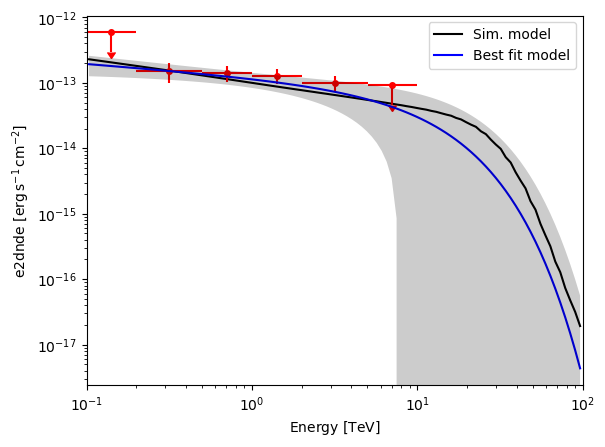

In [12]:
ax = dataset_original[0].spectral_model.plot(
    energy_bounds=[e_min, e_max] * u.TeV, 
    sed_type="e2dnde",
    label="Sim. model", 
    color='black'
    )

px = {"color": "red", "marker":"o"}
mx = {"color": "blue"}

# Fitting
# Quantify with the chi^2 statistic how well our parametric model of fit (that we made before) fits the spectral points
flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset_best.models[0])

flux_points_dataset.plot_spectrum(ax=ax, kwargs_fp=px, kwargs_model=mx)
#METHOD: Plot spectrum including flux points and model (defined in "flux_points_dataset")
#ax= axes to plot on; kwargs_fp= keywords for points; kwargs_model= keywords for model

ax.legend()
#ax.set_xlim(0.67,200)
#ax.set_ylim(2e-12,1e-10)

print(flux_points_dataset)

In [1]:
# === IMPORTS ===
import numpy as np
import matplotlib.pyplot as plt
import copy
from pathlib import Path

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

from gammapy.data import EventList
from gammapy.datasets import MapDataset, FluxPointsDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.estimators import FluxPointsEstimator

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
MainSource = "NGC1068"
e_min, e_max, e_bins = 0.1, 100.0, 10
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), e_bins) * u.TeV

center = SkyCoord.from_name(MainSource).icrs
offset = 0.5 * u.deg
pointing_position = center.directional_offset_by(position_angle=0 * u.deg, separation=offset)

ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100.0 TeV", nbin=10, per_decade=True)
WCS_GEOM = WcsGeom.create(skydir=pointing_position, width=(10, 10), binsz=0.02, frame="icrs", axes=[ENERGY_AXIS])

In [6]:
events_best = EventList.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/100sims/events/NGC1068_50hr_events_0.fits")
counts_best = Map.from_geom(WCS_GEOM)
counts_best.fill_events(events_best)

dataset_best = MapDataset.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/dataset_NGC1068_50hr.fits")
dataset_best.counts = counts_best
model_best = Models.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/100sims/best-fit/NGC1068_50hr_best-fit_0.yaml")
dataset_best.models = model_best
dataset_best.models[0].spectral_model.index.value = 2.239
dataset_best.models[0].spectral_model.index.error = 0.20
dataset_best.models[0].spectral_model.amplitude.value = 8.13e-14
dataset_best.models[0].spectral_model.amplitude.error = 4.0e-14
dataset_best.models[0].spectral_model.lambda_.value = 0.171
dataset_best.models[0].spectral_model.lambda_.error = 0.28
dataset_best.models[0].spectral_model.alpha.value = 3345441823.363
dataset_best.models[0].spectral_model.alpha.error = 33284762798.81
print(dataset_best.models)

DatasetModels

Component 0: SkyModel

  Name                      : NGC1068_Fermi
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.239   +/-    0.20             
    amplitude                     :   8.13e-14   +/- 4.0e-14 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.171   +/-    0.28 1 / TeV     
    alpha                         : 3345441823.363   +/- 33284762798.81             
    lon_0                 (frozen):     40.669       deg         
    lat_0                 (frozen):     -0.013       deg         

Component 1: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                   

In [7]:
fpe = FluxPointsEstimator(
energy_edges=e_edges,
source="NGC1068_Fermi",
selection_optional="all",
n_sigma=1,
n_sigma_ul=3,
n_jobs=7,
)
flux_points = fpe.run(datasets=dataset_best)
flux_points.sqrt_ts_threshold_ul = 3
flux_points.to_table(sed_type="dnde", formatted=True)

/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/astropy/units/quantity.py:671: Run

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
0.141,0.100,0.200,6.718e-12,3.291e-12,3.308e-12,3.275e-12,1.674e-11,4.255,2.063,3345324.8987311404,195.71898,-8794561.707,-8794557.452,-8794558.952 .. -8794504.611,True,3345731.0,True,0.200 .. 5.000
0.316,0.200,0.501,7.024e-13,3.128e-13,3.161e-13,3.094e-13,1.671e-12,5.306,2.304,1515662.47285377,104.03481,-384911.358,-384906.051,-384908.833 .. -384740.108,True,1514643.0,True,0.200 .. 5.000
0.708,0.501,1.000,2.027e-13,4.883e-14,4.996e-14,4.774e-14,3.592e-13,21.539,4.641,332716.60663562,78.32199,921990.324,922011.862,922004.374 .. 922113.358,False,332943.0,True,0.200 .. 5.000
1.413,1.000,1.995,3.726e-14,9.898e-15,1.027e-14,9.541e-15,7.027e-14,20.209,4.495,123901.97078810322,40.298653,637092.238,637112.447,637104.026 .. 637208.471,False,124160.0,True,0.200 .. 5.000
3.162,1.995,5.012,4.110e-15,1.490e-15,1.576e-15,1.407e-15,9.355e-15,11.623,3.409,60457.13690106045,18.993858,445135.892,445147.515,445140.740 .. 445254.840,False,60428.0,True,0.200 .. 5.000
7.079,5.012,10.000,0.000e+00,0.000e+00,0.000e+00,nan,0.000e+00,0.391,0.625,18371.887874365177,1.2322004,169991.520,169991.911,169991.638 .. 170001.469,True,18406.0,True,0.200 .. 5.000
14.125,10.000,19.953,0.000e+00,0.000e+00,nan,nan,nan,0.110,0.332,9139.568156291134,0.46952596,98427.076,98427.186,98427.186 .. 98427.186,True,9279.0,True,0.200 .. 5.000
31.623,19.953,50.119,-0.000e+00,0.000e+00,0.000e+00,0.000e+00,nan,0.000,-0.001,6102.255299203899,-1.115487e-06,72579.889,72579.889,72579.889 .. 72579.889,True,6071.0,True,0.200 .. 5.000


FluxPointsDataset
-----------------

  Name                            : BSbADw2u 

  Number of total flux points     : 9 
  Number of fit bins              : 3 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 2.22

  Number of models                : 1 
  Number of parameters            : 7
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : NGC1068_Fermi
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index                         :      2.239   +/-    0.20             
      amplitude                     :   8.13e-14   +/- 4.0e-14 1 / (TeV s cm2)
      reference             (frozen):      1.000       TeV         
      lambda_                       :      0.171   +/-    0.28 1 / TeV     
      alpha                         : 3345441823.363   +/- 33284762

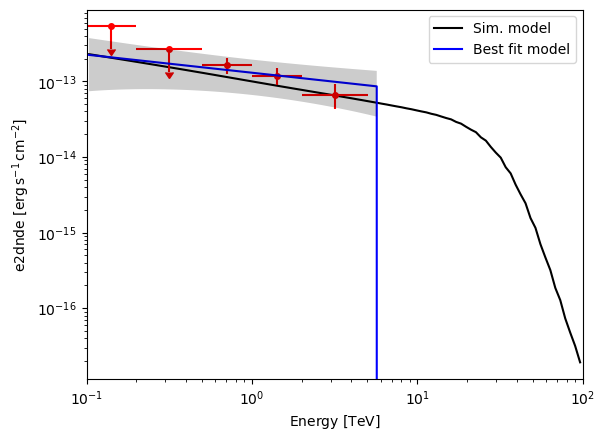

In [8]:
dataset_original = Models.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Fermi/NGC1068_Fermi.yaml")
ax = dataset_original[0].spectral_model.plot(
energy_bounds=[e_min, e_max] * u.TeV,
sed_type="e2dnde",
label="Sim. model",
color="black"
)

fp_dataset = FluxPointsDataset(data=flux_points, models=dataset_best.models[0])
fp_dataset.plot_spectrum(ax=ax, kwargs_fp={"color": "red", "marker": "o"}, kwargs_model={"color": "blue"})
ax.legend()
#save_figure(f"{MainSource}_flux_points_{ext}hr.png")
print(fp_dataset)